In [1]:
%matplotlib inline 
import os
import numpy as np
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange

from dldata.metrics.utils import compute_metric_base

Can't import separate mcc package
Can't import asgd.
Can't import scikits stuff


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# connect to database
dbname = 'final'
collname = 'yolo'
exp_id = 'imagenet'
port = 24444

conn = pm.MongoClient(port = port)
coll = conn[dbname][collname + '.files']

# print out saved experiments in collection coll
print(coll.distinct('exp_id'))

[u'in_test', u'imagenet']


In [3]:
from scipy.signal import convolve

def smooth_signal(lst, smooth=5):
    return convolve(lst, np.ones((smooth))/smooth, 'valid')

def get_losses(coll, exp_id):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])

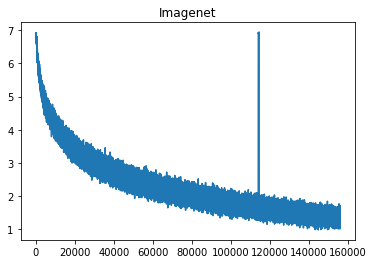

In [4]:

loss = get_losses(coll, exp_id)

# Plot the training loss

plt.figure()
plt.title('Imagenet')
plt.plot(loss)

In [5]:
def get_neural_validation_data(coll,exp_id):
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates': {'$exists' : True}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'validates', 'exp_id'])
    results = [val_steps[i] for i in range(val_steps.count())]
    for res in results:
        res['step'] = coll.find({'_id': res['validates']})[0]['step']
    return results

vd = get_neural_validation_data(coll,exp_id=exp_id)
print('data keys:')
print(vd[0]['validation_results'].keys())

data keys:
[u'V6', u'VAll']


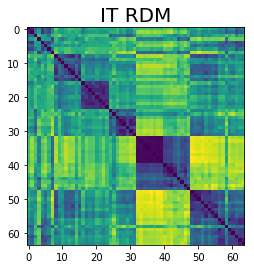

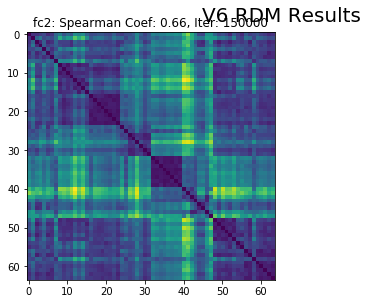

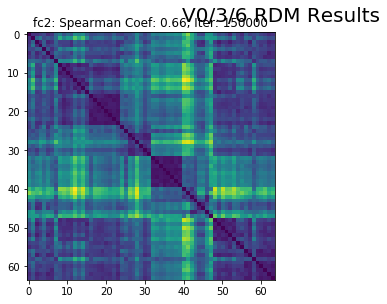

In [9]:

target_layers = ['fc2']
idx = 0 ### YOUR idx HERE
data_all = vd[idx]['validation_results']['VAll']
data_6 = vd[idx]['validation_results']['V6']
step = vd[idx]['step']

from math import ceil

def plot_rdms(data, target_layers, step):
    """
    Displays the RDMs of all target layers.
    """
    ncols = 2
    nrows = ceil(len(target_layers)/float(ncols))
    plot_size = 4
    f = plt.figure(figsize=(plot_size*ncols, plot_size*nrows))
    for i, layer in enumerate(target_layers):
        rdm = data['rdm_%s' % layer]
        spearman_corrcoef = data['spearman_corrcoef_%s' % layer]
        ### YOUR CODE HERE
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(rdm)
        plt.title('%s: Spearman Coef: %.2f, Iter: %s' % (layer, spearman_corrcoef, step))
        ### END OF YOUR CODE
    plt.tight_layout()


plt.title('IT RDM', fontsize=20)
plt.imshow(data_all['rdm_it'])

plot_rdms(data_6, target_layers, step)
plt.suptitle('V6 RDM Results', fontsize=20, y=1.02)

plot_rdms(data_all, target_layers, step)
plt.suptitle('V0/3/6 RDM Results', fontsize=20, y=1.02)
data_in = vd[0]['validation_results']['VAll']

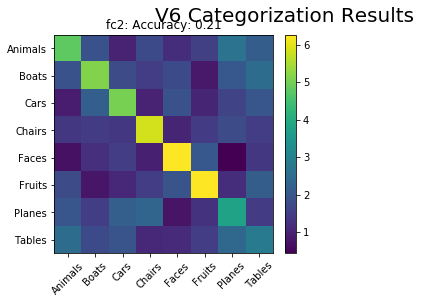

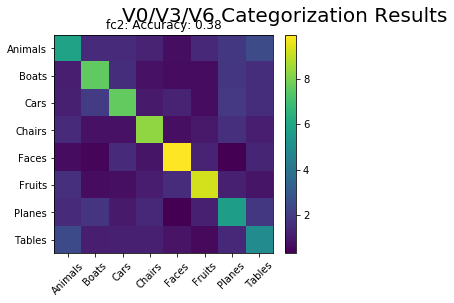

In [10]:
def plot_categorization_results(data, target_layers, step):
    """
    Plots the confusion matrix and the average classification accuracy for each layer.
    """
    ncols = 2
    nrows = 1
    plot_size = 4
    f = plt.figure(figsize=(plot_size*ncols, plot_size*nrows))

    for i, layer in enumerate(target_layers):
        k = 'categorization_%s' % layer
        categorization_results = data[k]['result_summary']
        confusion = np.vstack([np.mean(performance, 1) for performance in categorization_results['cms']])
        acc = (np.mean(categorization_results['accbal'])-.5)*2 # why this?
        # plot
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(confusion)
        plt.xticks(range(8), categorization_results['labelset'], rotation=45)
        plt.yticks(range(8), categorization_results['labelset'])
        plt.colorbar(fraction=.045)
        plt.title('%s: Accuracy: %.2f' % (layer, acc))
        ### END OF YOUR CODE
    plt.tight_layout()
        
plot_categorization_results(data_6, target_layers, step,)
plt.suptitle('V6 Categorization Results', fontsize=20, y=1.02)
plot_categorization_results(data_all, target_layers, step)
plt.suptitle('V0/V3/V6 Categorization Results', fontsize=20, y=1.02)


In [11]:
def plot_regression_results(data, target_layers, step):
    """
    Prints out the noise corrected multi rsquared loss for each layer.
    """
    for layer in target_layers:
        k = 'it_regression_%s' % layer
        regression_results = data[k]
        ### YOUR CODE HERE
        performance = 1-regression_results['noise_corrected_multi_rsquared_loss']
        print('layer: %s, step: %s, performance: %.2f' % (layer, step, performance))
        ### END OF YOUR CODE
        
print('********** V 6 *********************')
plot_regression_results(data_6, target_layers, step)
plot_regression_results(data_all, target_layers, step)

********** V 6 *********************
layer: fc2, step: 150000, performance: 0.26
layer: fc2, step: 150000, performance: 0.27
